a_i= [1.65184087e+00 5.95588414e-03 6.49561545e-05 3.25214854e-04
 5.91055903e-06] pc
r_ta= [2.66203959e-05 9.28637226e-05 2.05997377e-05 1.63568742e-04
 9.26538648e-05] pc
r_min= [1.65184087e-04 5.95588414e-08 6.49561545e-11 3.25214854e-11
 5.91055906e-14] pc


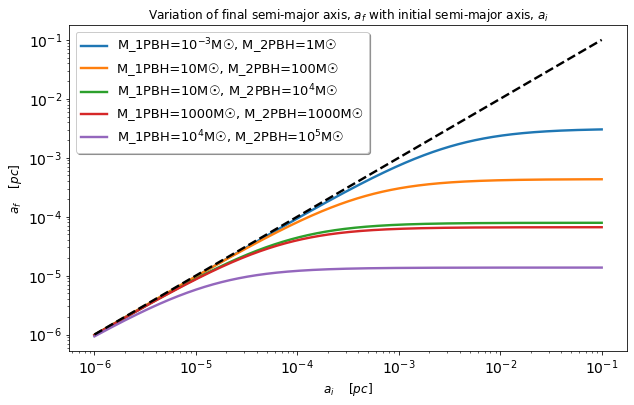

In [4]:
#When the dark matter halos are completely stripped away.

#Variation of the Final semi-major axis, a_f with initial semi-major axis a_i

import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


π=np.pi
G=4.4908e-15            #in units of M☉^-1 pc^3 yr^-2
ρ_eq=3.1811e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t_eq=5.0506e4           #in units of yr for t_eq = 1.59246e12 seconds


M_1PBH_list=[1e-3,10,10,1000,1e4]             #in units of M☉  
M_2PBH_list=[1,100,1e4,1000,1e5]              #in units of M☉


x=0.063     # in units of pc              # let say


λ_list=np.zeros(len(M_1PBH_list))

def λ_0(M_1PBH,M_2PBH): #λ_0 for the PBH binary
     return ((8*π*ρ_eq*(x**3))/(3*(M_1PBH+M_2PBH)))

for k, (M_1PBH,M_2PBH) in enumerate (zip(M_1PBH_list,M_2PBH_list)):
     λ_list[k]=λ_0(M_1PBH,M_2PBH) 

        
        
def h(x):
    return math.sqrt((x**-3)+(x**-4))   
def g(x):
    return  -((3*x+4)/(2*h(x)*(x**5))) #g(x)=h'(x).
    
    
def s_dec(λ_0):  #Function to calculate the s_decouple of the PBH binary
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ_0
                     *((u[0]**2+b**2)**(3/2))))]    #eq.(1) in reference pdf "M_DM at s_dec".
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=(As[i]*λ_0)              #s/λ at which the binary decouples.
        A=Bs[i] 
        if Δ<0:
            break
    return s


def semi(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ_0
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,(2*λ_0),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        a=((A/2)*λ_0)                   #as Bs=separations/λ_0.
        if Δ<0:
            break
    
    return a

s_dec_list=np.zeros(len(λ_list))
a_list=np.zeros(len(λ_list))


for j, λ_0 in enumerate (λ_list):
    s_dec_list[j]=s_dec(λ_0)
    a_list[j]=semi(λ_0)
print('a_i=',a_list,"pc")    

e_list=[0.9999,0.99999,0.999999,0.9999999,0.99999999]        
        
def r_min(e_i,a_i): #r_min of the PBH binary orbit
    return (a_i*(1-e_i)) 

def t_dec(s_dec):  #time of the binary decouple
    return (((3/(8*π*G*ρ_eq))**(1/4))*(((2/3)*(s_dec-2)*((s_dec+1)**(1/2))+(4/3))**(1/2)))

def r_ta(M_PBH,s_dec): #r_turnaround of the dark matter halos
    return ((4*G*M_PBH*t_dec(s_dec))**(1/3))

r_ta_list=np.zeros(len(λ_list))


for j, (M_PBH,s_dec) in enumerate (zip(M_1PBH_list,s_dec_list)):
    r_ta_list[j]=r_ta(M_PBH,s_dec)
    
print("r_ta=",r_ta_list,"pc")    


def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 

def M_DM(M_PBH): #Mass of the dark matter halos
    return ((16/3)*π*ρ_bar(M_PBH)*((r_ta(M_PBH,s_dec))**(3/4)))
            
def M_1(M_1PBH):
    return (M_1PBH+M_DM(M_1PBH))
            
def M_2(M_2PBH):
    return (M_2PBH+M_DM(M_2PBH)) 

def E_1(M_PBH):
    return (16*π*G*ρ_bar(M_PBH)*M_PBH*((r_min/2)**(-1/4)))

def E_2(M_PBH):
    return  (((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2))*((3*r_ta(M_PBH,s_dec)**(1/2))-((r_min/2)**(1/2))))

def E_b(M_PBH):#Binding  energy of the dark matter halo
    return (-E_1(M_PBH)- E_2(M_PBH))
            
def a_f(a_i,M_1PBH,M_2PBH): #Final semi-major axis
    return ((G*M_1PBH*M_2PBH*a_i)/((G*M_1(M_1PBH)*M_2(M_2PBH))-(2*a_i*(E_b(M_1PBH)+E_b(M_2PBH)))))


r_min_list=np.zeros(len(a_list))
for k, (e_i,a_i) in enumerate (zip(e_list,a_list)):
     r_min_list[k]=r_min(e_i,a_i)

print("r_min=",r_min_list,"pc")

a_i=np.linspace(1e-6,1e-1,10000000)  #in units of pc
fig, ax = plt.subplots( sharex=True, figsize=(10,6))
for i, (r_min,s_dec) in enumerate (zip(r_min_list,s_dec_list)):
    ax.loglog(a_i,a_f(a_i,M_1PBH,M_2PBH))


def a_final(a_i):
    return a_i
plt.loglog(a_i,a_final(a_i),'k--')    
    
plt.rc('lines', linewidth=2.4)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(["M_1PBH=$10^{-3}$M☉, M_2PBH=1M☉","M_1PBH=10M☉, M_2PBH=100M☉","M_1PBH=10M☉, M_2PBH=$10^{4}$M☉","M_1PBH=1000M☉, M_2PBH=1000M☉","M_1PBH=$10^{4}$M☉, M_2PBH=$10^{5}$M☉"],prop = {'size' :13},
           loc='upper left',shadow = True, facecolor = 'white',fontsize=19)
plt.xlabel('$a_{i}\hspace{1.3}[pc]$',fontsize=12)
plt.ylabel('$a_{f}\hspace{1.3}[pc]$',fontsize=12)
plt.title('Variation of final semi-major axis, $a_{f}$ with initial semi-major axis, $a_{i}$')
plt.show()                 